In [1]:
import sys 
sys.path.append('/home/voehring/voehring/opt/scCCA')

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sagar87/scCCA/blob/main/docs/notebooks/PBMC5K.ipynb)

# Analysing PBMC5K using scCCA

In [2]:
import pandas as pd
import scanpy as sc
import scCCA as scc

## Preprocessing

In this tutorial we illustrate how to apply `scCCA` to the 10X PBMC5K dataset. We start by loading the the data using `scanpy`. Note that we have to pass the `gex_only=False` argument to avoid dropping the ADT counts.

In [3]:
adata = sc.read_10x_h5('/home/voehring/voehring/projects/2022-05-14_10XCiteseq/5k_pbmc_protein_v3_filtered_feature_bc_matrix.h5', gex_only=False)

/home/voehring/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
adata.var_names_make_unique()

Now, we separate the protein data from the RNA count matrix and store it separately in the `adata.obsm` field. The following lines of code extract the protein names and barcodes to create a `pandas.DataFrame` for the protein count data.

In [5]:
col_names = adata.var[adata.var.feature_types == 'Antibody Capture'].gene_ids.tolist() 
row_names = adata.obs.index.tolist()

In [6]:
protein_counts = adata[:, adata.var.feature_types == 'Antibody Capture'].X.toarray()

Before we save the protein count table to the `adata` object, we drop the control ADTs IgG1, IgG2 and IgG2b. Finally, we subset the `adata` object such that `adata.X` contains RNA counts only, while the ADT data is stored in `adata.obsm['protein_expression']`.

In [7]:
adata.obsm['protein_expression'] = pd.DataFrame(protein_counts, index=row_names, columns=col_names).drop(columns=['IgG1', 'IgG2a', 'IgG2b'])

In [8]:
adata = adata[:, adata.var.feature_types == 'Gene Expression']

## HVG selection

Next, we select highly variable genes from the data. We employ the `highly_variable_genes` function from `scanpy` using the `seurat_v3` settings which directly operates on count data (that is in contrast to other HVG selection procedures that require some sort of preprocessing). Supplying the `subset=True` argument drops all unneccessary features from the data such that we can directly proceed by fitting the `scCCA` model.

In [9]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    flavor="seurat_v3",
    subset=True,
)

/home/voehring/.local/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


## Model training

Training the `scCCA` model is easy for this simple data set. All we need to provide is the `adata` object, the number of factors we want to fit and the respective `obsm` key for the protein data. The `scCCA` constructor returns a `scCCA` model instance which we can train by calling its `fit` method.

In [10]:
m0 = scc.scCCA(adata, num_factors=15, protein_obsm_key='protein_expression')

In [11]:
m0.fit()

  0%|          | 0/5000 [00:00<?, ?it/s]/home/voehring/voehring/opt/scCCA/scCCA/model.py:144: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2985.)
  α_rna = deterministic("α_rna", (1 / α_rna_inv).T)
Epoch: 4990 | lr: 1.00E-02 | ELBO: 4216514 | Δ_10: 11731.50 | Best: 4164478: 100%|██████████| 5000/5000 [06:14<00:00, 13.35it/s] 


In many cases it is adviseable to train the model for a few additional epochs with a smaller learning rate. We can call the `fit` method for a second time and pass the arguments `lr=0.001` to continue the training with a learning rate of 0.001 (initally it was 0.01).

In [12]:
m0.fit(lr=0.001)

Epoch: 9990 | lr: 1.00E-03 | ELBO: 4176325 | Δ_10: 14536.00 | Best: 4141708: 100%|██████████| 5000/5000 [05:49<00:00, 14.30it/s] 


To obtain the posterior mean of the fitted model parameters we call the `to_anndata` function and pass a sensible `model_key` argument. The `scCCA` class will save the loadings and factors in `adata.varm[model_key]` and `adata.obsm[f'X_{model_key}']`, respectively. Additional metadata and parameters are saved to `adata.uns[model_key]`.

In [13]:
m0.to_anndata(model_key='rank15')

Predicting z for obs 4096-5246.: 100%|██████████| 3/3 [00:00<00:00,  3.79it/s]


### Model fit

Before moving on with more elaborate downstream analyses, we assess the fit of the model by using the following plotting functions.

<AxesSubplot: title={'center': 'RMSE 10.47'}, xlabel='True count ($\\log_{10}(x+1)$ scaled)', ylabel='Predicted count ($\\log_{10}(x+1)$ scaled)'>

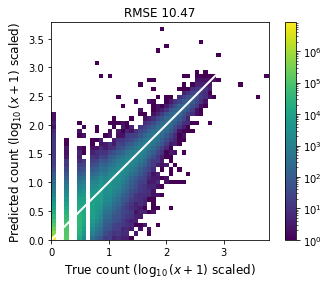

In [14]:
scc.pl.qc_hist(adata, model_key='rank15')

<AxesSubplot: title={'center': 'RMSE 25759.37'}, xlabel='True count ($\\log_{10}(x+1)$ scaled)', ylabel='Predicted count ($\\log_{10}(x+1)$ scaled)'>

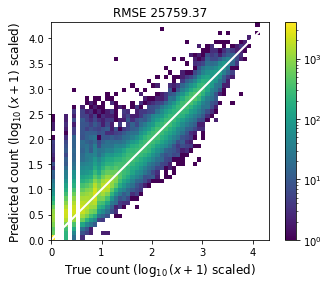

In [16]:
scc.pl.qc_hist(adata, model_key='rank15', protein_obsm_key='protein_expression')

## Down stream analysis

Once we trust our model we can proceed with our prefered pipeline to analyse CITE-seq data.

In [19]:
sc.pp.neighbors(adata, use_rep='X_rank15')

In [20]:
sc.tl.umap(adata)

In [24]:
sc.tl.leiden(adata)

/home/voehring/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


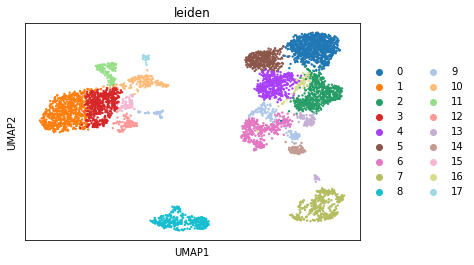

In [25]:
sc.pl.umap(adata, color='leiden')

In [36]:
adata.obs = pd.concat([adata.obs, adata.obsm['protein_expression']], axis=1)

In [41]:
adata.obs

,leiden,CD3,CD4,CD8a,CD11b,CD14,CD15,CD16,CD19,CD20,...,CD86,CD127,CD137,CD197,CD274,CD278,CD335,PD-1,HLA-DR,TIGIT
AAACCCAAGAGACAAG-1,1,25.0,164.0,16.0,3011.0,696.0,19.0,10.0,6.0,10.0,...,317.0,2.0,8.0,6.0,1.0,10.0,4.0,7.0,573.0,10.0
AAACCCAAGGCCTAGA-1,0,959.0,720.0,8.0,12.0,12.0,9.0,4.0,5.0,6.0,...,2.0,37.0,0.0,10.0,3.0,121.0,5.0,17.0,15.0,3.0
AAACCCAGTCGTGCCA-1,2,942.0,1647.0,21.0,11.0,13.0,8.0,7.0,0.0,7.0,...,3.0,117.0,7.0,15.0,4.0,92.0,12.0,39.0,11.0,3.0
AAACCCATCGTGCATA-1,2,802.0,1666.0,5.0,11.0,9.0,8.0,3.0,3.0,9.0,...,6.0,157.0,3.0,3.0,5.0,44.0,6.0,15.0,19.0,3.0
AAACGAAAGACAAGCC-1,12,529.0,542.0,4.0,1285.0,311.0,6.0,2.0,2.0,6.0,...,47.0,31.0,4.0,6.0,0.0,17.0,1.0,4.0,42.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCAGCACAAG-1,6,693.0,9.0,737.0,20.0,15.0,6.0,1.0,1.0,14.0,...,4.0,7.0,1.0,12.0,3.0,146.0,5.0,34.0,23.0,14.0
TTTGTTGCAGTCTTCC-1,2,402.0,1417.0,8.0,15.0,9.0,14.0,2.0,2.0,5.0,...,3.0,145.0,1.0,2.0,1.0,65.0,8.0,11.0,6.0,2.0
TTTGTTGCATGGCCCA-1,9,401.0,1.0,222.0,7.0,17.0,6.0,1.0,2.0,9.0,...,0.0,14.0,0.0,1.0,2.0,40.0,0.0,8.0,40.0,15.0
TTTGTTGCATTGCCGG-1,1,6.0,46.0,3.0,1027.0,382.0,1.0,4.0,4.0,1.0,...,144.0,0.0,3.0,7.0,0.0,3.0,1.0,3.0,184.0,1.0


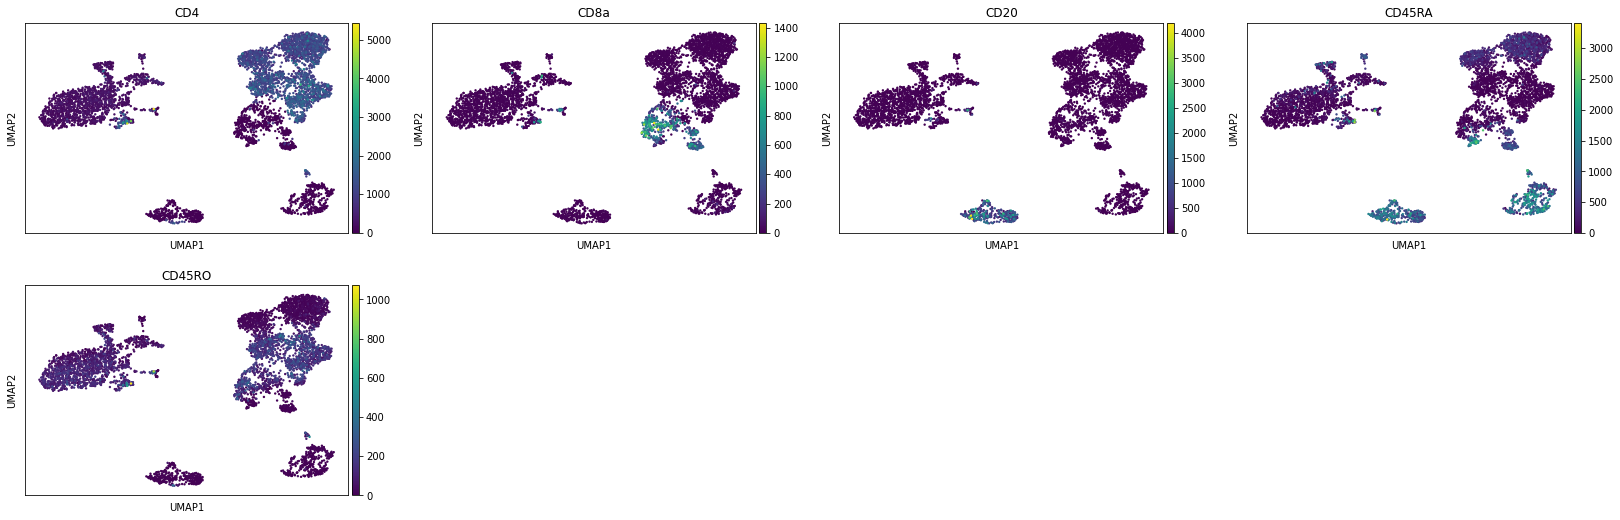

In [44]:
sc.pl.umap(adata, color=['CD4', 'CD8a', 'CD20', 'CD45RA', 'CD45RO'])